In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pencil as pc
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid as trap
from astropy.convolution import convolve, Box1DKernel
import modes
from IPython.display import display, Latex

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


: 

In [2]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()

In [ ]:
xyaver = pc.read.aver(plane_list=['xy'])

In [ ]:
yaver = pc.read.aver(plane_list='y')

In [ ]:
class Phase(modes.modes):
    """
    To analyze different phases
    """

    def __init__(self, path, t1, t2, z_ref, norm, sim, ts, xyaver, yaver, ini=False, dyn=True):
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=True)

        self.path = path
        self.t = self.yaver.t
        self.z_ref = z_ref
        self.norm = norm

        self.kf = super().get_kf()
        self.indx_t1 = np.argmin(np.abs(self.yaver.t-t1))
        self.indx_t2 = np.argmin(np.abs(self.yaver.t-t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, self.norm)
        # self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        self.upto_indx = super().upto(self.indx_t1, self.indx_t2)

    def indx_k(self, k_xtil:np.ndarray):
        indx = np.argmin(np.abs(self.k_til-k_xtil))
        return indx
    
    def Power(self, indx:int):
        # P = np.exp(self.log_P[:self.upto_indx,indx])
        P = np.exp(self.log_P[np.argmin(np.abs(self.om_til-0)):,indx])
        return P
    
    def Power_filtered(self, power:np.ndarray, sigma):
        # P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        P_filt = gaussian_filter(power[np.argmin(np.abs(self.om_til-0)):],sigma)
        return P_filt
    
    def f_freq(self, k_tilx, qq=False):
        # freq = round(self.fmodes(k_tilx),3)
        freq = self.fmodes(k_tilx, qq)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = self.pmodes(k_tilx,num)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def plot(self, ax, P:np.ndarray, **kwargs):
        ax.plot(self.om_til[np.argmin(np.abs(self.om_til-0)):], P, **kwargs)
        # ax.grid()
        # ax.set_ylim(0,)
        ax.legend()

    def xlim(self, x_data:np.ndarray):
        x_data = x_data[np.argmin(np.abs(self.om_til-0)):]
        min = x_data[0]
        max = x_data[-1]
        return (min,max)
    
    def cs_du(self, k_tilx):
        csd = self.cs_d*k_tilx/(self.L0*self.omega0)
        csu = self.cs_u*k_tilx/(self.L0*self.omega0)
        return (csd, csu)
    
    def mode_mass(self, x_data, y_data, u_d, **kwargs):
        """
        Calculate mode mass by integrating
        y_data in the interval x_data
        x_data: \omega_tilde range for a mode
        y_data: corresponding P(\omega_tilde)
        u_d: rms velocity in lower layer
        """
        # if kinematic == True:
        #     u_d = 0.1244
        # elif saturated == True:
        #     u_d = 0.0988
        # else:
        #     u_d = 1     #NOTE: not normalized
        norm = u_d/(3*self.kf)
        mass = trap(y_data, x=x_data)
        norm_mass = mass/norm
        return np.round(norm_mass, 4)

    def shift(self, f_om_calc, f_om):
        """
        Calculate relative freq shift from
        calculated \omega_f and theoretical
        \omega_f
        """
        return np.round((f_om_calc**2-f_om**2)/f_om**2, 4)

    def indx_fwhm(self, P_om, om_f, peak_f):
        """
        P_om: fitted spectrum (i.e., P(\omega)
        of P(\omega) vs \omega )
        om_f: freq range around \omega_f
        peak_f: freq of f mode calculated
        from fitting
        """
        indx_peak = np.argmin(np.abs(om_f-peak_f))
        peak = P_om[indx_peak]
        lh = np.argmin(np.abs(P_om[:indx_peak]-peak/2))
        uh = indx_peak + np.argmin(np.abs(P_om[indx_peak+1:]-peak/2))
        return [lh, uh]
    
    def line_width(self, om_f, indx_fwhm, f_om):
        return np.round((om_f[int(indx_fwhm[1])] - om_f[int(indx_fwhm[0])])/f_om, 4)

    def mode_fit_para(self, func, x_data, y_data, **kwargs):
        para, _ = curve_fit(func, x_data, y_data, **kwargs)
        return para
    
    def mode_fit_extend(self, func, x, para, cont=True):
        if cont:
            y = func(x, *para)
        else:
            y = func(x, *para)-x*para[4]-para[3]
        return y

    pass

In [ ]:
path = './plots/'

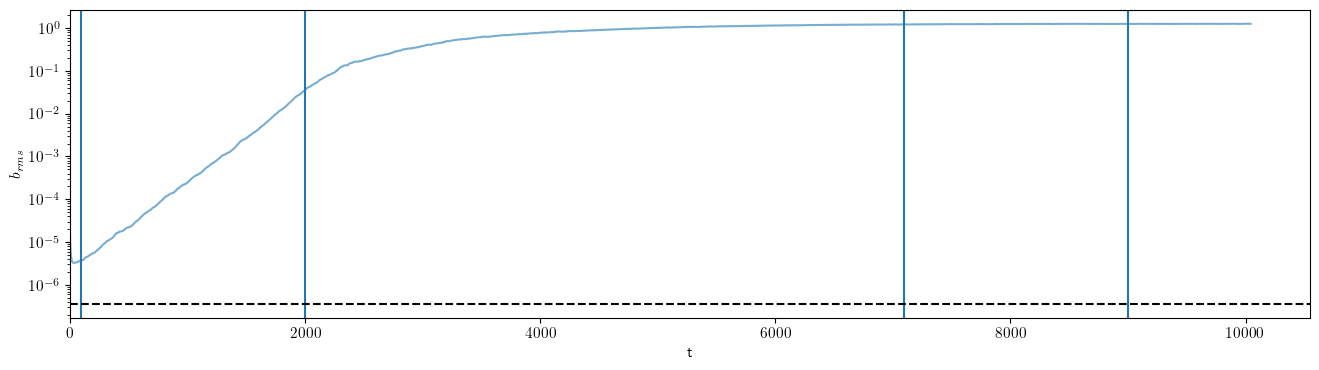

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.semilogy(ts.t, ts.brms, alpha=0.6)
# plt.axvline(x=yaver.t[indx_sat_d], c='k', ls=':')
plt.axvline(x=ts.t[np.argmin(np.abs(ts.t-100))])
plt.axvline(x=ts.t[np.argmin(np.abs(ts.t-2000))])
plt.axvline(x=ts.t[np.argmin(np.abs(ts.t-7100))])
plt.axvline(x=ts.t[np.argmin(np.abs(ts.t-9000))])
plt.axhline(y=3.64415e-07, c='k', ls='--')
# plt.axhline(y=ts.brms[-1])
#plt.plot(t_fit, u_fit, '--r')
plt.yscale('log')
plt.xlim(0,)
plt.xlabel("t")
plt.ylabel(r"$b_{rms}$")
plt.show()

In [ ]:
kinematic = Phase(path, 100, 2000, 225, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
saturated = Phase(path, 7100, 9000, 225, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)

In [ ]:
indx_kin = []
indx_sat = []

# for i in [2,3,4,5]:
for i in [1,2,3,4]:
    indx_kin.append(kinematic.indx_k(i))
    indx_sat.append(saturated.indx_k(i))

In [ ]:
indx_kin

[203, 205, 208, 210]

In [ ]:
P_kin = kinematic.Power(indx_kin).T
P_sat = saturated.Power(indx_sat).T

In [ ]:
P_kin.shape

(4, 2375)

In [ ]:
label_kin = []
P_kin_filt = np.empty(np.shape(P_kin))
P_sat_filt = np.empty(np.shape(P_sat))
for i, indx in enumerate(indx_kin):
    P_kin_filt[i,:] =convolve(P_kin[i,:], Box1DKernel(5))
    label_kin.append(kinematic.k_til[:kinematic.upto_indx][indx])
    P_sat_filt[i,:] =convolve(P_sat[i,:], Box1DKernel(5))

In [ ]:
label_kin
label_sat = label_kin

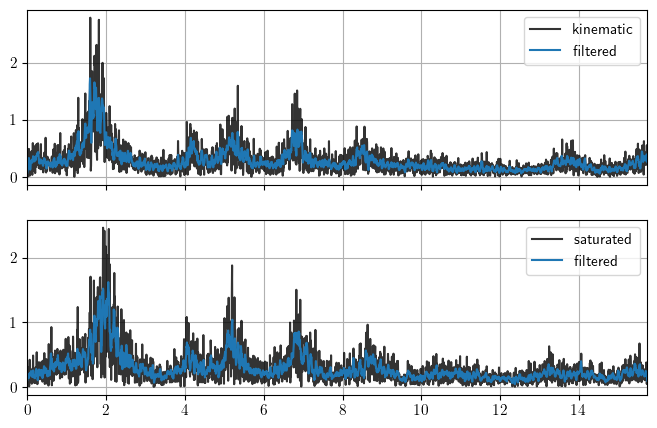

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,

kinematic.plot(axs[0], P_kin[1], label='kinematic', c='k', alpha=0.8)
kinematic.plot(axs[0], P_kin_filt[1], label='filtered')
saturated.plot(axs[1], P_sat[1], label='saturated', c='k', alpha=0.8)
saturated.plot(axs[1], P_sat_filt[1], label='filtered')

# axs[1].set_xlim(0,kinematic.om_til[kinematic.upto_indx-1])
axs[1].set_xlim(kinematic.xlim(kinematic.om_til))
# axs[1].set_ylim(0,1.75)
axs[0].grid()
axs[1].grid()

### $\omega$ of f-modes at the corresponding $k_x$

In [ ]:
f_om = kinematic.f_freq(kinematic.k_til[indx_kin], qq=True)
f_om = kinematic.fmodes(kinematic.k_til[indx_kin])
f_om

array([1.08540839, 1.4012562 , 1.77246447, 1.98167552])

In [ ]:
def pmodes(kx, n: int):
    """
    Calculate the freq of p-mode.
    n: order of p-modes, 0, 1, 2, 3, ...
    """
    om_sq = kinematic.gz**2/(2*kinematic.cs_d)**2+kinematic.cs_d**2*((kx/kinematic.L0)**2+((n+0.5)*np.pi/(9*kinematic.lz/10))**2)
    # om_sq = kinematic.gz**2/(2*kinematic.cs_d)**2+kinematic.cs_d**2*((kx)**2+((n+0.5)*np.pi/(9*kinematic.lz/10))**2)
    freq = np.sqrt(om_sq/kinematic.omega0**2)
    return np.round(freq, 3)

In [ ]:
p0_om = kinematic.pmodes(kinematic.k_til[indx_kin], 0)
p1_om = kinematic.pmodes(kinematic.k_til[indx_kin], 1)
p1_om

array([3.58305914, 3.91225681, 4.61737366, 5.18380948])

In [ ]:
how_many = 4

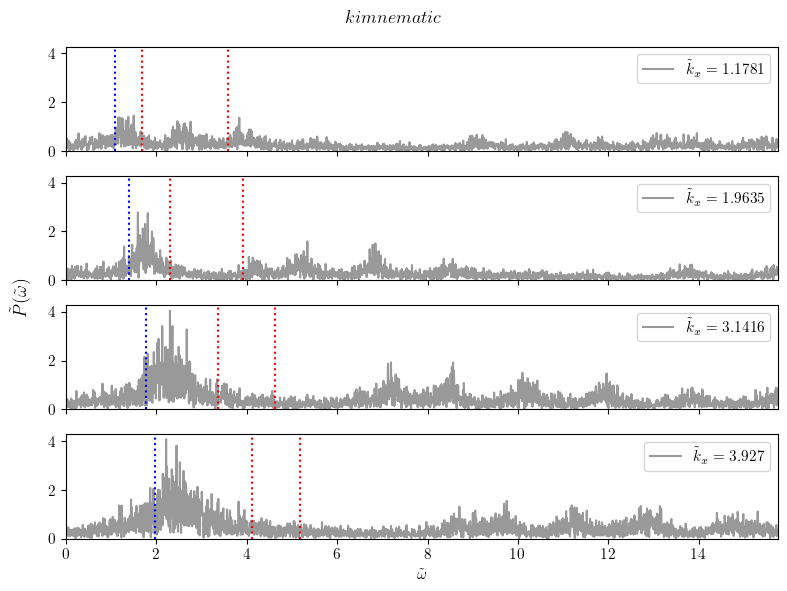

In [ ]:
hm = how_many
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,6))#sharex=True,
# fig, axs = plt.subplots(4,1, sharey=True, figsize=(8,6))#sharex=True,

for i in range(4):
    kinematic.plot(axs[i], P_kin[i], c='k', alpha=0.4, label=fr'$\tilde{{k}}_x={round(label_kin[i],4)}$')
    axs[i].axvline(x=f_om[i], ls=':', c='b')
    axs[i].axvline(x=p0_om[i], ls=':', c='r')
    axs[i].axvline(x=p1_om[i], ls=':', c='r')

axs[1].set_xlim(kinematic.xlim(kinematic.om_til))
axs[0].set_ylim(0,)
axs[0].legend()

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kimnematic$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,5))#sharex=True,

# for i in range(4):
#     saturated.plot(axs[i], P_sat[i], c='k', alpha=0.4, label=fr'$\tilde{{k}}_x={round(label_sat[i],3)}$')
#     axs[i].axvline(x=f_om[i], ls=':', c='b')

# axs[1].set_xlim(saturated.xlim(saturated.om_til[:saturated.upto_indx-1]))
# axs[0].set_ylim(0,)
# axs[0].legend()

# plt.xlabel(r"$\tilde{\omega}$")
# fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.suptitle(r"$saturated$")
# #plt.yscale('log')
# plt.tight_layout()
# plt.show()

In [ ]:
om_kin = kinematic.om_til[np.argmin(np.abs(kinematic.om_til-0)):]
# indx_f = np.argmin(np.abs(om_kin-f_om))
idl_f_kin = []
idu_f_kin = []
P_f_kin = []
om_f_kin = []

# d = [1.12, 1.5, 1.7, 2.0]
# u = [2.10, 2.2, 2.5, 2.6]

d = [0.5, 0.8, 0.8, 1.0]
u = [1.2, 1.6, 2.2, 2.6]

for i in range(hm):
    idl_f_kin.append(np.argmin(np.abs(om_kin - d[i])))
    idu_f_kin.append(np.argmin(np.abs(om_kin - u[i])))

    # P_f_kin.append(P_kin[i, idl_f_kin[i]:idu_f_kin[i]])
    P_f_kin.append(P_kin_filt[i, idl_f_kin[i]:idu_f_kin[i]])
    om_f_kin.append(om_kin[idl_f_kin[i]:idu_f_kin[i]])

In [ ]:
# plt.style.use('ggplot')

IndexError: list index out of range

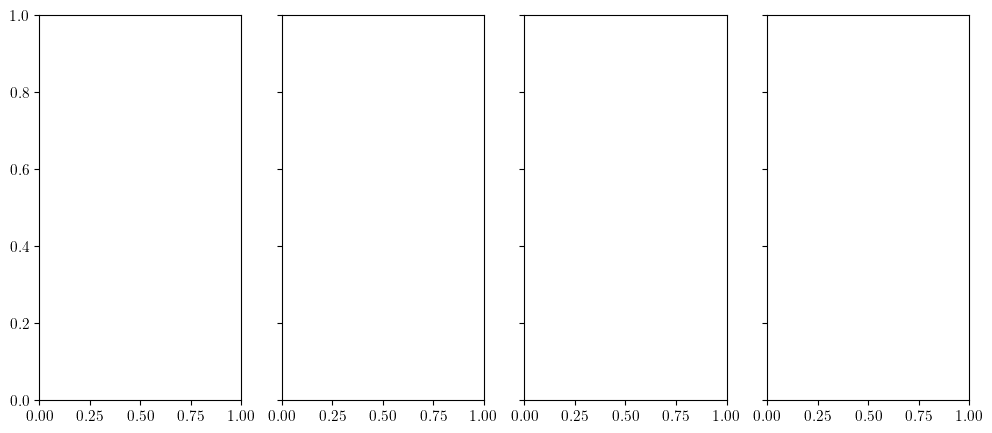

In [ ]:
fig, axs = plt.subplots(1,hm, sharey=True, figsize=(12,5))#sharex=True,

for i in range(hm):
    axs[i].plot(om_f_kin[i], P_f_kin[i], c='k', ls=':', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')
    axs[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    # axs[i].axvline(x=f_om[i], ls=':', c='b')
    # axs[i].set_xlim(om_f_kin[i][i], om_f_kin[i][-1])
    axs[i].legend()

axs[0].set_ylim(0,)

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kimnematic$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# om_sat = saturated.om_til[:saturated.upto_indx]
# # indx_f = np.argmin(np.abs(om_sat-f_om))
# idl_f_sat = []
# idu_f_sat = []
# P_f_sat = []
# om_f_sat = []

# # d = [1.12, 1.5, 1.7, 2.0]
# # u = [2.10, 2.2, 2.5, 2.6]

# d = [0.23, 0.35, 0.4, 0.4]
# u = [0.8, 1.2, 1.6, 1.7]

# for i in range(hm):
#     idl_f_sat.append(np.argmin(np.abs(om_sat - d[i])))
#     idu_f_sat.append(np.argmin(np.abs(om_sat - u[i])))

#     # P_f_sat.append(P_sat[i, idl_f_sat[i]:idu_f_sat[i]])
#     P_f_sat.append(P_sat_filt[i, idl_f_sat[i]:idu_f_sat[i]])
#     om_f_sat.append(om_sat[idl_f_sat[i]:idu_f_sat[i]])

In [ ]:
# fig, axs = plt.subplots(1,hm, sharey=True, figsize=(12,5))#sharex=True,

# for i in range(hm):
#     axs[i].plot(om_f_sat[i], P_f_sat[i], c='k', ls=':', label=fr'$\tilde{{k}}_x={round(label_sat[i],3)}$')
#     axs[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
#     # axs[i].axvline(x=f_om[i], ls=':', c='b')
#     axs[i].set_xlim(om_f_sat[i][i], om_f_sat[i][-1])
#     axs[i].legend()

# axs[0].set_ylim(0,)

# plt.xlabel(r"$\tilde{\omega}$")
# fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.suptitle(r"$saturated$")
# #plt.yscale('log')
# # plt.ylim(0,1)
# plt.tight_layout()
# plt.show()

### fitting function

In [ ]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

In [ ]:
para_f_kin = np.zeros((hm,5))
para_f_sat = np.zeros((hm,5))

a_kin = [0.6, 0.4, 0.4, 0.8]
# b_kin = [1.6, 1.7, 2.1, 2.3]
b_kin = [0.81, 1.25, 1.55, 1.9]
d_kin = [-7.7, -1.0, -1.0, -1.0]
e_kin = [0.4, 0.1, 0.1, 0.1]

a_sat = [0.6, 0.4, 0.4, 0.8]
# b_sat = [1.6, 1.7, 2.2, 2.3]
b_sat = [0.5, 0.7, 0.9, 1.1]
d_sat = [-7.7, -1.0, -1.0, -1.0]
e_sat = [0.4, 0.1, 0.1, 0.1]


x_kin = np.zeros((hm,2000))
y_kin = np.zeros((hm,2000))
x_sat = np.zeros((hm,2000))
y_sat = np.zeros((hm,2000))

for i in range(hm):
    para_f_kin[i,:] = kinematic.mode_fit_para(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]))
    x_kin[i] = np.linspace(para_f_kin[i,1]-1.0, para_f_kin[i,1]+1.0, 2000)
    y_kin[i] = kinematic.mode_fit_extend(lorentzian, x_kin[i], para_f_kin[i,:], cont=True)

    # para_f_sat[i,:] = saturated.mode_fit_para(lorentzian, om_f_sat[i], P_f_sat[i], p0 = np.array([a_sat[i],b_sat[i],-2,d_sat[i],e_sat[i]]))
    # x_sat[i] = np.linspace(para_f_sat[i,1]-1.0, para_f_sat[i,1]+1.0, 2000)
    # y_sat[i] = saturated.mode_fit_extend(lorentzian, x_sat[i], para_f_sat[i,:])

In [ ]:
np.shape(x_kin)

(4, 2000)

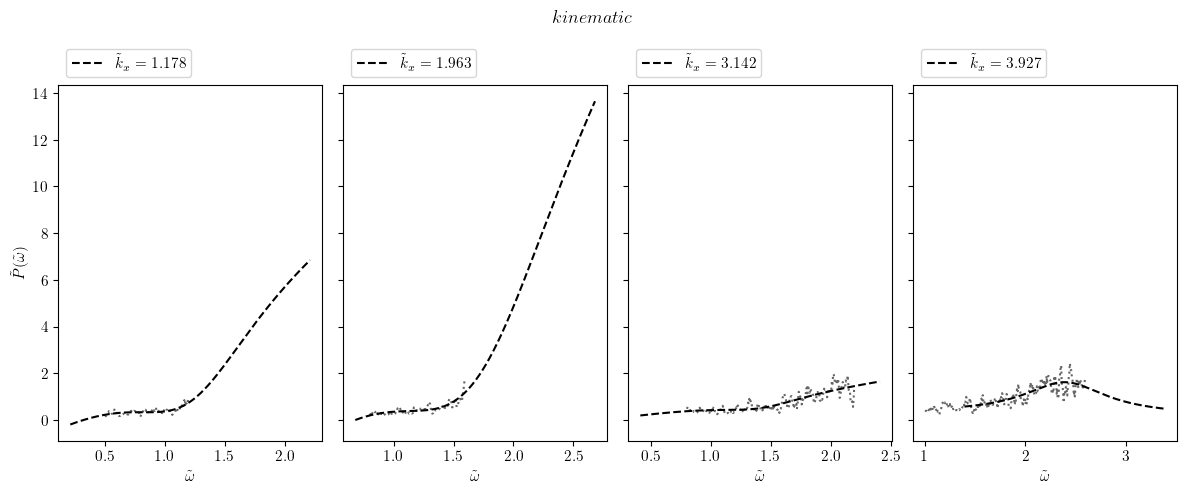

In [ ]:
fig, axes = plt.subplots(1,hm, sharey=True, figsize=(12,5))
for i in range(hm):
    axes[i].plot(om_f_kin[i], P_f_kin[i], color='k', ls=":", alpha=0.6)#, label=r'$kinematic$ $phase$')
    axes[i].plot(x_kin[i], y_kin[i], ls='--', color='k', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')#fitted_f_kin_lor-para_f_kin_lor[3],
    # axes[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    axes[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
    axes[i].set_xlabel(r"$\tilde{\omega}$")

# axes[1].set_xlabel(r"$\tilde{\omega}$")
axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kinematic$")
plt.tight_layout()
plt.show()

In [ ]:
# fig, axes = plt.subplots(1,hm, sharey=True, figsize=(12,5))
# for i in range(hm):
#     axes[i].plot(om_f_sat[i], P_f_sat[i], color='k', ls=":", alpha=0.6)#, label=r'$saturated$ $phase$')
#     axes[i].plot(x_sat[i], y_sat[1], ls=':', color='k', label=fr'$\tilde{{k}}_x={round(label_sat[i],3)}$')#fitted_f_sat_lor-para_f_sat_lor[3],
#     # axes[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
#     axes[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
#     axes[i].set_xlabel(r"$\tilde{\omega}$")

# # axes[1].set_xlabel(r"$\tilde{\omega}$")
# axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.suptitle(r"$saturated$")
# plt.tight_layout()
# plt.show()

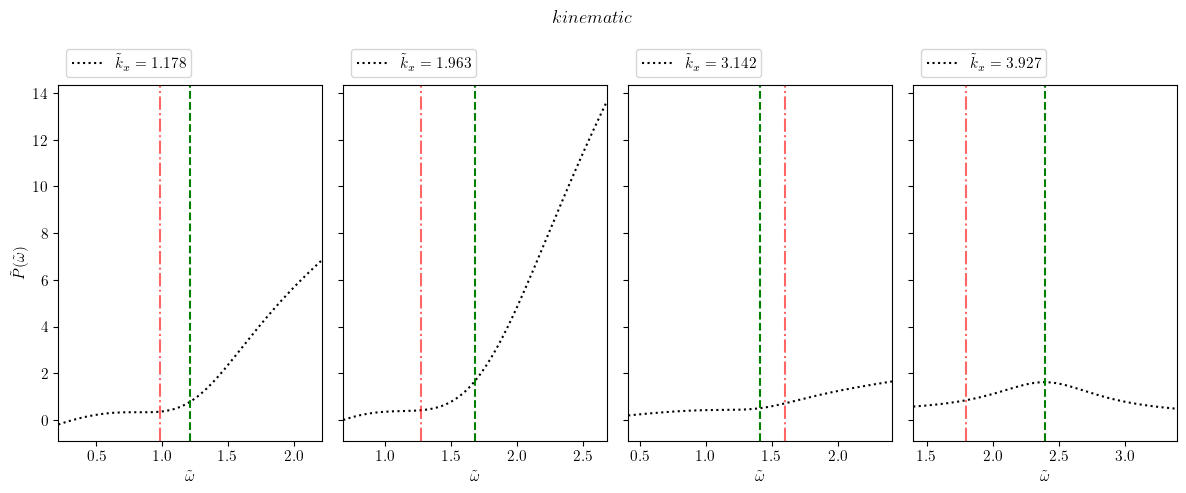

In [ ]:
fig, ax = plt.subplots(1,hm, sharey=True, figsize=(12,5))
for i in range(hm):
    ax[i].plot(x_kin[i], y_kin[i], ls=':', color='k', label=fr'$\tilde{{k}}_x={round(label_kin[i],3)}$')#fitted_f_kin_lor-para_f_kin_lor[3],
    ax[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    ax[i].axvline(x=para_f_kin[i][1], ls='--', c='g')
    ax[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
    ax[i].set_xlim(x_kin[i][i], x_kin[i][-1])
    # ax[i].set_ylim(0,)
    ax[i].set_xlabel(r"$\tilde{\omega}$")

# ax[1].set_xlabel(r"$\tilde{\omega}$")
ax[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$kinematic$")
plt.tight_layout()
plt.show()

In [ ]:
para_f_kin[0]

array([-1.71508527,  1.21174532, -0.77312245,  0.24058399,  3.51774477])

/tmp/ipykernel_4067397/921317167.py:7: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.



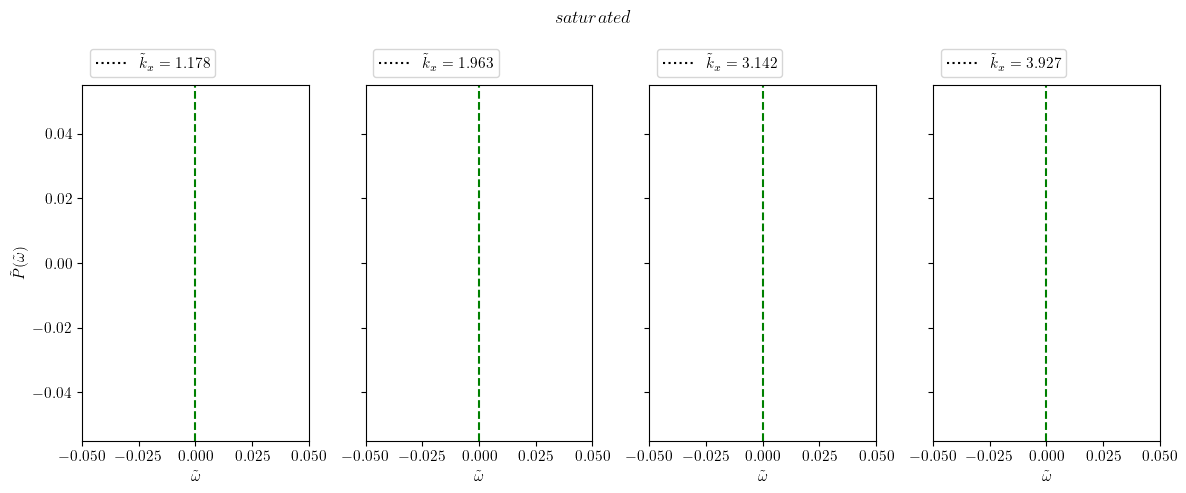

In [ ]:
fig, ax = plt.subplots(1,hm, sharey=True, figsize=(12,5))
for i in range(hm):
    ax[i].plot(x_sat[i], y_sat[i], ls=':', color='k', label=fr'$\tilde{{k}}_x={round(label_sat[i],3)}$')#fitted_f_sat_lor-para_f_sat_lor[3],
    ax[i].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
    ax[i].axvline(x=para_f_sat[i][1], ls='--', c='g')
    ax[i].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
    ax[i].set_xlim(x_sat[i][i], x_sat[i][-1])
    # ax[i].set_ylim(0,)
    ax[i].set_xlabel(r"$\tilde{\omega}$")

# ax[1].set_xlabel(r"$\tilde{\omega}$")
ax[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$saturated$")
plt.tight_layout()
plt.show()

### Characteristics

In [ ]:
def ave(*args):
    list = [*args]
    arr = np.array(list)
    return round(np.sum(arr)/len(list),4)

In [ ]:
# def u_rms_d(self, var):#, prnt=False):
#         uu = var.uu
#         if uu[1].shape == (self.nzgrid,self.nygrid,self.nxgrid):
#             uu_d = var.uu[:,:self.indx_zref,:,:]
#         else:
#             uu_d = var.uu[:,3:self.indx_zref+3,3:-3,3:-3]
#         # if prnt: print(uu_d.shape)
#         uu_d_sq = uu_d**2
#         uu_d_sq_sum = np.sum(uu_d_sq, axis=0)
#         u_rms_d = np.sqrt(np.average(uu_d_sq_sum))
#         u_rms_d = round(u_rms_d, 4)
#         return u_rms_d

In [ ]:
# var6.uu.shape

In [ ]:
# var6 = pc.read.var('VAR6')
# var8 = pc.read.var('VAR8')
# # var12 = pc.read.var('VAR12')
# # var18 = pc.read.var('VAR18')
# u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var8))
# # u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var12), kinematic.u_rms_d(var18))

In [ ]:
u_d_kin = 0.1794    #NOTE: the value is calculated by above method

In [ ]:
mode_mass_kin = np.zeros(hm)
shift_kin = np.zeros(hm)
indx_fwhm_kin = np.zeros((hm,2))
ln_wd_kin = np.zeros(hm)

for i in range(hm):
    mode_mass_kin[i] = kinematic.mode_mass(x_kin[i], y_kin[i], u_d_kin)#; mode_mass_sat = mode_mass(f_sat[0], f_sat[1], u_d_sat)
    shift_kin[i] = kinematic.shift(para_f_kin[i,1], f_om[i])
    indx_fwhm_kin[i,:] = kinematic.indx_fwhm(y_kin[i], x_kin[i], para_f_kin[i,1])
    ln_wd_kin[i] = kinematic.line_width(x_kin[i,:], indx_fwhm_kin[i,:], f_om[i])

In [ ]:
para_f_kin[2,1]

1.4111997366218734

In [ ]:
indx_fwhm_kin

array([[ 816., 1000.],
       [ 835., 1000.],
       [ 102., 1000.],
       [ 364., 1581.]])

In [ ]:
np.shape(x_kin)

(4, 2000)

In [ ]:
mode_mass_kin

array([353.0943, 678.5504, 128.8577, 175.4464])

In [ ]:
shift_kin

array([ 0.5247,  0.7597, -0.2245,  0.7838])

In [ ]:
ln_wd_kin

array([0.1876, 0.1303, 0.5607, 0.6796])

In [ ]:
def st_line(x,a,b):
    return a*x+b

para_st_kin, _ = curve_fit(st_line, label_kin, shift_kin)

x_kin = np.linspace(label_kin[0], label_kin[-1], 100)
y_kin = st_line(x_kin, *para_st_kin)

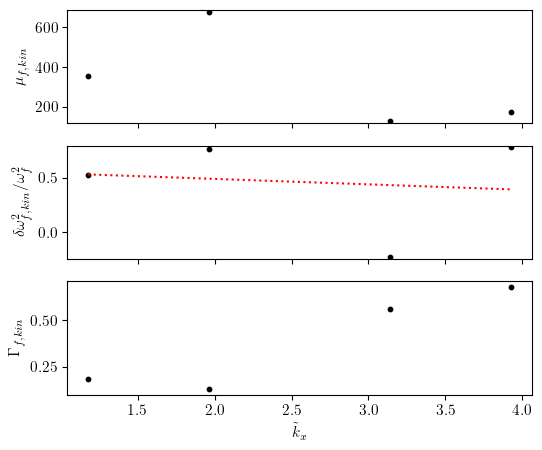

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,5))
size = 10
ax[0].scatter(label_kin, mode_mass_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],
ax[1].scatter(label_kin, shift_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],
ax[2].scatter(label_kin, ln_wd_kin, color='k', s=size)#fitted_f_kin_lor-para_f_kin_lor[3],

ax[1].plot(x_kin, y_kin, c='r', ls=':')

ax[0].set_ylim(np.min(mode_mass_kin)-10, np.max(mode_mass_kin)+10)
ax[1].set_ylim(np.min(shift_kin)-0.02, np.max(shift_kin)+0.01)
ax[2].set_ylim(np.min(ln_wd_kin)-0.03, np.max(ln_wd_kin)+0.03)

ax[0].set_ylabel(r'$\mu_{f,kin}$')
ax[1].set_ylabel(r'$\delta\omega_{f,kin}^2/\omega_f^2$')
ax[2].set_ylabel(r'$\Gamma_{f,kin}$')
plt.xlabel(r'$\tilde{k}_x$')
plt.savefig('./plots/modes.png', dpi=300)
plt.show()

In [ ]:
indx_fwhm_kin[0,1]

1000.0

In [ ]:
# x_kin[0,1108]

In [ ]:
(1.6798-1.4617)/f_om[0]

0.2222504156574826

In [ ]:
# fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))
# # [indx]
# ## ax.plot(f_kin[0], f_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ## ax.scatter(f_kin[0][indx_fwhm_kin], f_kin[1][indx_fwhm_kin])

# ax.plot(x_kin[0], y_kin[0], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.scatter([1.4617, 1.6798], [0.1278, 0.129])

In [ ]:
f_om[1]

1.2668857713328625

In [ ]:
para_f_kin[2][1]

1.4111997366218734

In [ ]:
indx_fwhm_kin[2,:][0]

102.0

In [ ]:
x_kin[1]

1.2058638468324459

In [ ]:
# var6 = pc.read.var('VAR6')
# var12 = pc.read.var('VAR12')
# var18 = pc.read.var('VAR18')
# u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var12), kinematic.u_rms_d(var18))

In [ ]:
u_d_kin

0.1794

In [ ]:
u_d_kin = 0.1246    #NOTE: the value is calculated by above method


In [ ]:
# u_d_sat = ave(saturated.u_rms_d(var6), saturated.u_rms_d(var12), saturated.u_rms_d(var18))

In [ ]:
u_d_sat = 0.1246

In [ ]:
mode_mass_sat = np.zeros(hm)
shift_sat = np.zeros(hm)
indx_fwhm_sat = np.zeros((hm,2))
ln_wd_sat = np.zeros(hm)

for i in range(hm):
    mode_mass_sat[i] = saturated.mode_mass(x_sat[i], y_sat[i], u_d_sat)#; mode_mass_sat = mode_mass(f_sat[0], f_sat[1], u_d_sat)
    shift_sat[i] = saturated.shift(para_f_sat[i,1], f_om[i])
    indx_fwhm_sat[i,:] = saturated.indx_fwhm(y_sat[i], x_sat[i], para_f_sat[i,1])
    ln_wd_sat[i] = saturated.line_width(x_sat[i,:], indx_fwhm_sat[i,:], f_om[i])

NameError: name 'saturated' is not defined

In [ ]:
def st_line(x,a,b):
    return a*x+b

para_st_sat, _ = curve_fit(st_line, label_sat, shift_sat)

x_sat = np.linspace(label_sat[0], label_sat[-1], 100)
y_sat = st_line(x_sat, *para_st_sat)

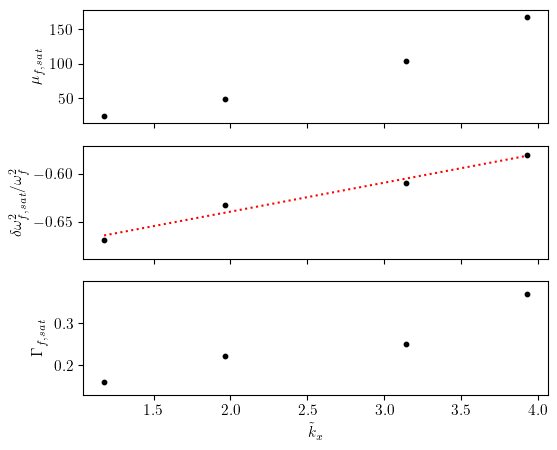

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,5))
size = 10
ax[0].scatter(label_sat, mode_mass_sat, color='k', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],
ax[1].scatter(label_sat, shift_sat, color='k', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],
ax[2].scatter(label_sat, ln_wd_sat, color='k', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],

ax[1].plot(x_sat, y_sat, c='r', ls=':')

ax[0].set_ylim(np.min(mode_mass_sat)-10, np.max(mode_mass_sat)+10)
ax[1].set_ylim(np.min(shift_sat)-0.02, np.max(shift_sat)+0.01)
ax[2].set_ylim(np.min(ln_wd_sat)-0.03, np.max(ln_wd_sat)+0.03)

ax[0].set_ylabel(r'$\mu_{f,sat}$')
ax[1].set_ylabel(r'$\delta\omega_{f,sat}^2/\omega_f^2$')
ax[2].set_ylabel(r'$\Gamma_{f,sat}$')
plt.xlabel(r'$\tilde{k}_x$')
plt.savefig('./plots/modes.png', dpi=300)
plt.show()

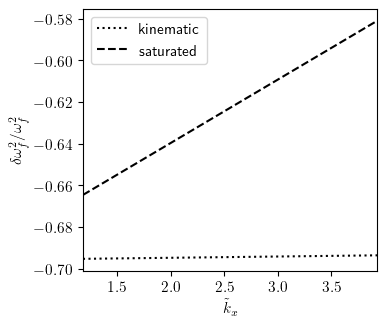

In [ ]:
# fig = plt.subplots(figsize=(4,2))
# plt.style.use('dark_background')
fig = plt.subplots(figsize=(4,3.4))

plt.plot(x_kin, y_kin, c='k', ls=':', label='kinematic')
plt.plot(x_sat, y_sat, c='k', ls='--', label='saturated')
plt.xlim(np.min(x_kin), np.max(x_kin))
plt.xlabel(r'$\tilde{k}_x$', fontsize=11)
plt.ylabel(r'$\delta\omega_f^2/\omega_f^2$', fontsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
# plt.savefig('./plots/shift.png', dpi=150)
plt.show()

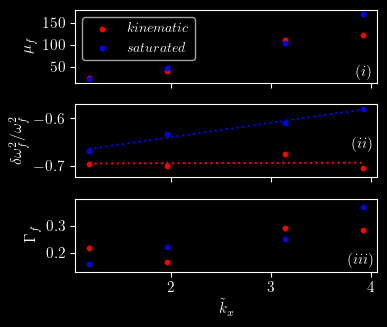

In [ ]:
# fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,5))
plt.style.use('dark_background')

fig, ax = plt.subplots(3,1, sharex=True, figsize=(4,3.4))
size = 10
ax[0].scatter(label_kin, mode_mass_kin, color='r', s=size, label=r'$kinematic$')#fitted_f_sat_lor-para_f_sat_lor[3],
ax[0].scatter(label_sat, mode_mass_sat, color='b', s=size, label=r'$saturated$')#fitted_f_sat_lor-para_f_sat_lor[3],
ax[1].scatter(label_kin, shift_kin, color='r', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],
ax[1].scatter(label_sat, shift_sat, color='b', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],
ax[2].scatter(label_kin, ln_wd_kin, color='r', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],
ax[2].scatter(label_sat, ln_wd_sat, color='b', s=size)#fitted_f_sat_lor-para_f_sat_lor[3],

ax[1].plot(x_kin, y_kin, c='r', ls=':')
ax[1].plot(x_sat, y_sat, c='b', ls=':')

ax[0].set_ylim(np.min(mode_mass_sat)-10, np.max(mode_mass_sat)+10)
ax[1].set_ylim(np.min([shift_sat, shift_kin])-0.02, np.max([shift_sat, shift_kin])+0.01)
ax[2].set_ylim(np.min(ln_wd_sat)-0.03, np.max(ln_wd_sat)+0.03)

ax[0].text(0.96, 0.15, r'$(i)$', horizontalalignment='center',
     verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.955, 0.45, r'$(ii)$', horizontalalignment='center',
     verticalalignment='center', transform=ax[1].transAxes)
ax[2].text(0.95, 0.15, r'$(iii)$', horizontalalignment='center',
     verticalalignment='center', transform=ax[2].transAxes)

ax[0].set_ylabel(r'$\mu_{f}$')
ax[1].set_ylabel(r'$\delta\omega_{f}^2/\omega_f^2$')
ax[2].set_ylabel(r'$\Gamma_{f}$')
plt.xlabel(r'$\tilde{k}_x$')
ax[0].legend(fontsize=10)
plt.tight_layout()
plt.savefig('./plots/modes_ppt.png', dpi=300)
plt.show()